In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("../data/bodyPerformance.csv")

print(df.head())
print(df.info())
print(df.describe())

    age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   
3  32.0      M      174.5      71.10        18.4       76.0     147.0   
4  28.0      M      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
0       54.9                     18.4            60.0          217.0     C  
1       36.4                     16.3            53.0          229.0     A  
2       44.8                     12.0            49.0          181.0     C  
3       41.4                     15.2            53.0          219.0     B  
4       43.5                     27.1            45.0          217.0     B  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 

### **Descripción**

- Hay 13.393 registros y 12 columnas.

- Las variables son en su mayoría numéricas, salvo gender y class.

- El rango de edad es de 21 a 64 años.

### **Normalizando los nombres de las columnas**


Pudimos observar que los nombres de las columnas no son consistentes, por lo que se procede a normalizarlos, para poder trabajar de manera más eficiente.

In [4]:
# Normalizar nombres de columnas
df.columns = (
    df.columns.str.strip()  # quitar espacios al inicio/final
              .str.lower()  # todo en minúscula
              .str.replace(' ', '_')  # espacios a guiones bajos
              .str.replace('-', '_')  # guiones a guiones bajos
              .str.replace('%', 'percent')  # % a "percent"
              .str.replace('[^0-9a-zA-Z_]', '')  # quitar cualquier otro caracter raro
)
print(df.columns.tolist())

['age', 'gender', 'height_cm', 'weight_kg', 'body_fat_percent', 'diastolic', 'systolic', 'gripforce', 'sit_and_bend_forward_cm', 'sit_ups_counts', 'broad_jump_cm', 'class']


### **Corroborando si algunas columnas tienen valores mínimos sospechosos, lo cual podría indicar datos erróneos.**

In [5]:
# Count zeros in each column of the dataset
zeros_per_column = (df == 0).sum()

# Show only columns that have at least one zero
columns_with_zeros = zeros_per_column[zeros_per_column > 0]
print("\nColumns containing at least one zero value:")
print(columns_with_zeros)


Columns containing at least one zero value:
diastolic                    1
systolic                     1
gripforce                    3
sit_and_bend_forward_cm     12
sit_ups_counts             125
broad_jump_cm               10
dtype: int64


### **Podemos observar que en las columnas anteriores hay ceros que procederemos a eliminar o bien a reemplazar por la media de cada columna.**

- **Presión arterial (diastolic y systolic):**


        Solo hay 1 valor cero en cada una, lo cual es muy poco, la presión arterial nunca puede ser cero en una persona viva, así que estos son claramente errores o datos faltantes.

- **gripforce (fuerza de agarre):**


        3 valores cero, la fuerza de agarre no debería ser cero en personas sanas.

- **sit_and_bend_forward_cm (flexibilidad):**


        12 valores cero, podría ser un valor válido en algunas pruebas de flexibilidad, pero es sospechoso.

- **sit_ups_counts (abdominales):**


        125 valores cero - este es un número significativo, cero abdominales podría ser un valor válido si la persona no pudo realizar ninguno.

- **broad_jump_cm (salto de longitud):**


        10 valores cero, un salto de 0 cm no es posible físicamente.

In [6]:
# Crear una copia del dataset original para preservarlo
df_original = df.copy()
df_clean = df.copy()

# Reemplazando ceros con mediana para diastolic, systolic, y sit_and_bend_forward_cm
columns_to_replace = ['diastolic', 'systolic', 'sit_and_bend_forward_cm']
for column in columns_to_replace:
    # Calcular mediana de valores
    median_value = df_clean[df_clean[column] > 0][column].median()
    # Reemplazar ceros con mediana
    df_clean.loc[df_clean[column] == 0, column] = median_value
    print(f"Reemplazados ceros en {column} con valor mediana: {median_value:.2f}")

# Eliminando filas donde gripforce o broad_jump_cm es cero
rows_before = len(df_clean)
df_clean = df_clean[(df_clean['gripforce'] > 0) & (df_clean['broad_jump_cm'] > 0)]
rows_after = len(df_clean)
removed_rows = rows_before - rows_after

print(f"Tamaño del nuevo dataset limpio: {rows_after} filas")

# Guardar el dataset limpio en un archivo CSV
df_clean.to_csv('../data/clean_data.csv', index=False)

print("\nAhora tienes dos DataFrames:")
print("- df_original: El dataset original sin modificaciones")
print("- df_clean: El dataset limpio con los cambios aplicados")


Reemplazados ceros en diastolic con valor mediana: 79.00
Reemplazados ceros en systolic con valor mediana: 130.00
Reemplazados ceros en sit_and_bend_forward_cm con valor mediana: 16.60
Tamaño del nuevo dataset limpio: 13380 filas

Ahora tienes dos DataFrames:
- df_original: El dataset original sin modificaciones
- df_clean: El dataset limpio con los cambios aplicados


* **Columnas donde reemplazamos ceros con la mediana**:
   * `diastolic`
   * `systolic`
   * `sit_and_bend_forward_cm`
* **Columnas donde eliminamos las filas que contenian cero** 
   * `gripforce`
   * `broad_jump_cm`

### **Calculando el indice de masa corporal**

In [32]:
df['height_m'] = df['height_cm'] / 100
df['bmi'] = df['weight_kg'] / (df['height_m'] ** 2)
print(df[['height_cm', 'weight_kg', 'bmi']].head())

   height_cm  weight_kg        bmi
0      172.3      75.24  25.344179
1      165.0      55.80  20.495868
2      179.6      78.00  24.181428
3      174.5      71.10  23.349562
4      173.8      67.70  22.412439


### **Visualizaremos las categorías en la columna Class. (A, B, C, D)**

['C' 'A' 'B' 'D']


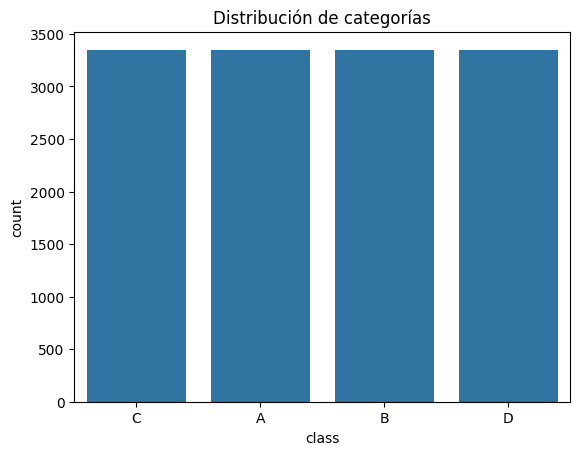

In [7]:
if 'class' in df.columns:
    print(df['class'].unique())
else:
    print("La columna de categorías no se encuentra, verifica el nombre.")

sns.countplot(x='class', data=df)
plt.title("Distribución de categorías")
plt.show()



**🏷️Categorías de rendimiento físico**

Las clases están bastante balanceadas:

    Clase A: 3348

    Clase B: 3347

    Clase C: 3349

    Clase D: 3349

In [8]:
df = pd.read_csv("../data/clean_data.csv")

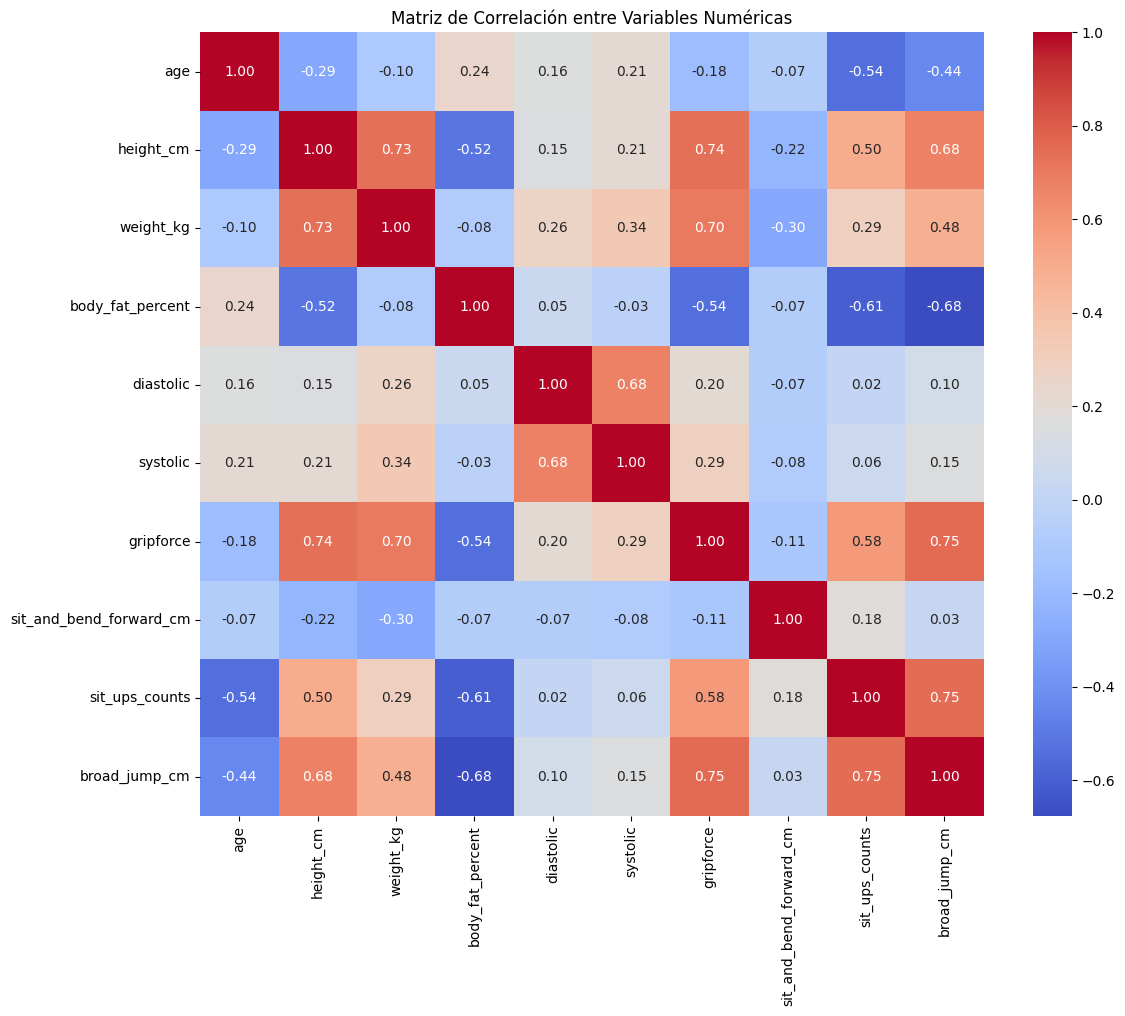

In [9]:
numeric_cols = df.select_dtypes(include=['float64']).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

### **📌 Hallazgos clave:**

- **Altura y peso** muestran correlación positiva fuerte (0.73), lo cual es esperado antropométricamente

- **Altura y fuerza de agarre** presentan correlación alta (0.74), sugiriendo que las personas más altas tienden a tener mayor fuerza prensil
- **Peso y BMI** tienen la correlación más alta (0.84), lo que es lógico pues el BMI se calcula a partir del peso
- **Porcentaje de grasa corporal** correlaciona negativamente con rendimiento físico (broad_jump_cm: -0.67)
- **Edad** correlaciona negativamente con sit_ups_counts (-0.54), lo que indica disminución del rendimiento en abdominales conforme aumenta la edad
- **Presión arterial (sistólica y diastólica)** muestran correlación moderada-alta (0.68) entre sí
- **Rendimiento en pruebas físicas** como broad_jump_cm, sit_ups_counts y gripforce están altamente correlacionadas entre sí, sugiriendo un factor común de aptitud física

### **Distribución de las variables numéricas**
Veremos distribuidos los datos en cada columna:

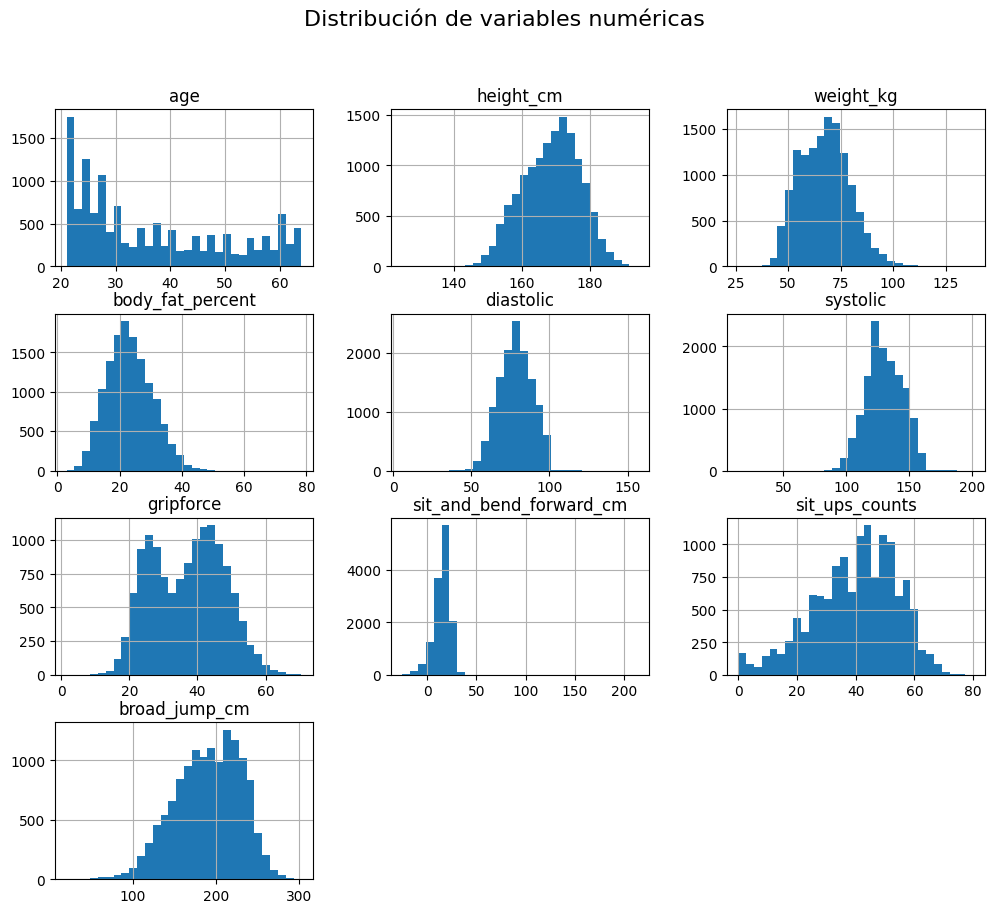

In [10]:
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()

- **Edad:** Distribución bimodal con mayor concentración en adultos jóvenes y mediana edad

- **Altura (height_cm):** Distribución normal centrada aproximadamente en 170 cm
- **Peso (weight_kg):** Distribución normal ligeramente sesgada a la derecha con media alrededor de 70 kg
- **Porcentaje de grasa corporal:** Distribución aproximadamente normal centrada en ~25%
- **Presión arterial diastólica:** Concentrada entre 70-90 mmHg
- **Presión arterial sistólica:** Concentrada principalmente entre 120-140 mmHg
- **Fuerza de agarre (gripforce):** Distribución bimodal (posiblemente reflejando diferencias de género)
- **Sit and bend forward:** Muchos valores cercanos a cero o negativos, indicando limitada flexibilidad
- **Sit-ups counts:** Distribución amplia desde 0 hasta ~70 repeticiones
- **Broad jump:** Distribución aproximadamente normal centrada en ~170-180 cm

### **Boxplots para analizar la variabilidad y posibles valores atípicos**
Esto es útil para ver la dispersión de los datos y detectar outliers:

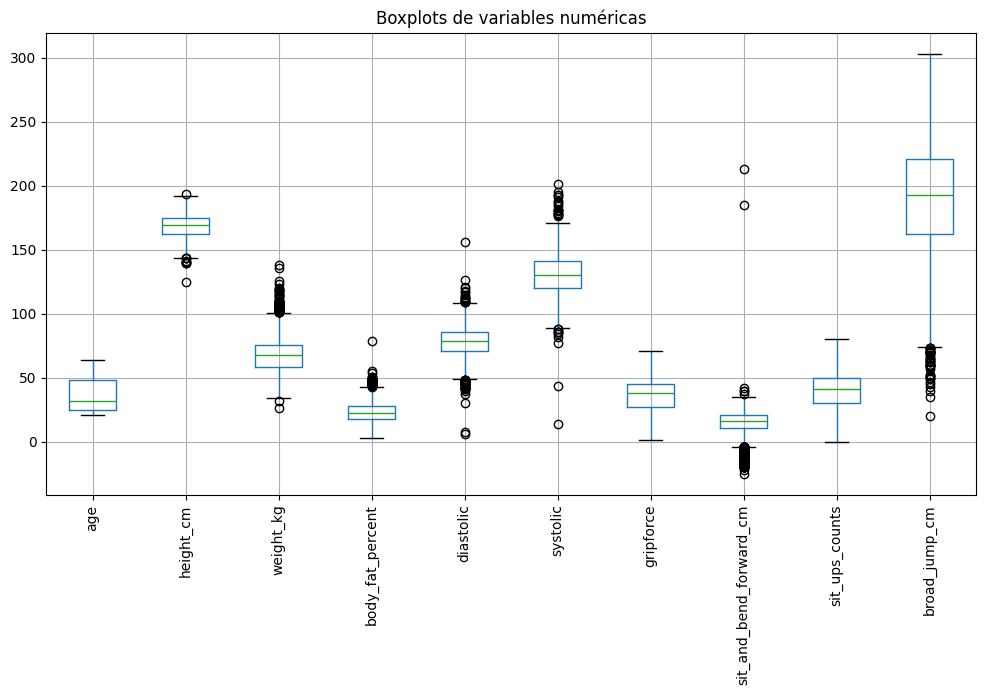

In [11]:
df = pd.read_csv("../data/clean_data.csv")
plt.figure(figsize=(12,6))
df.boxplot(rot=90)
plt.title("Boxplots de variables numéricas")
plt.show()

- **Distribución de variables:** Cada boxplot muestra el rango intercuartílico (caja), la mediana (línea dentro de la caja), los "bigotes" (extensiones) y valores atípicos (puntos individuales).

- **Variables antropométricas:**
height_cm: Presenta valores alrededor de 160-180 cm, con poca dispersión y pocos valores atípicos.
weight_kg: Muestra una distribución centrada aproximadamente en 70 kg.
body_fat_percent: Tiene valores bajos (20-30%) con algunos valores atípicos.

- **Variables médicas:**
diastolic y systolic: Representan presión arterial, con valores típicos para systolic entre 120-140 y diastolic entre 70-90.
age: Muestra una distribución con mediana alrededor de 30 años.

- **Variables de rendimiento físico:**
sit_and_bend_forward_cm: Medición de flexibilidad con valores moderados.
sit_ups_counts: Número de abdominales, con distribución amplia.
broad_jump_cm: Salto de longitud, con la mayor variabilidad y valores entre 150-220 cm aproximadamente.
gripforce: Probablemente fuerza de agarre, con distribución moderada.

- **Comportamiento de los datos:**
broad_jump_cm presenta la mayor dispersión y algunos valores atípicos extremos.
Variables como sit_and_bend_forward_cm muestran valores negativos, lo que podría indicar una medición relativa a un punto de referencia.
Varios boxplots muestran valores atípicos, particularmente notables en systolic y height_cm.

**Hallazgos principales:**

- **Edad:** Mediana aproximadamente 35 años, con distribución amplia

- **Altura:** Mediana alrededor de 170 cm con pocos valores extremos

- **Peso:** Distribución relativamente simétrica centrada en ~70 kg

- **Body_fat_percent:** Mediana aproximadamente 25% con algunos valores atípicos superiores

- **Presión arterial:** Valores normales para población general

- **Sit and bend forward:** Muchos valores cercanos a cero, con valores negativos significativos, que pueden ser porque no se puede completar la prueba fisica
- **Broad jump:** Amplio rango de valores, reflejando gran variabilidad en capacidad de salto
Todas las variables muestran valores atípicos (outliers), especialmente broad jump y algunas medidas de rendimiento físico

### **Gráfico de violín por categoría**
Este gráfico ayudará a ver la distribución de una variable según la categoría:

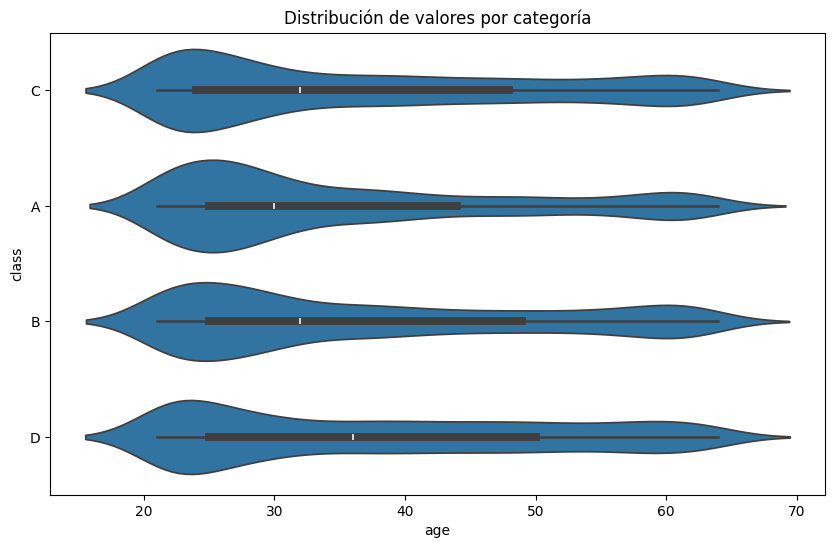

In [39]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="age", y="class", data=df) 
plt.title("Distribución de valores por categoría")
plt.show()

- Todas las clases muestran distribuciones de edad similares con ligeras variaciones

- Las cuatro clases presentan una distribución bimodal de edad
- Las medianas (líneas blancas) son muy similares entre clases
- La distribución de edad no parece ser un factor determinante en la clasificación
- Todas las clases abarcan aproximadamente el mismo rango de edad (20-70 años)

### **Heatmap de correlación con más detalle**
Visualizar cómo están distribuidas la columna categorica gender:

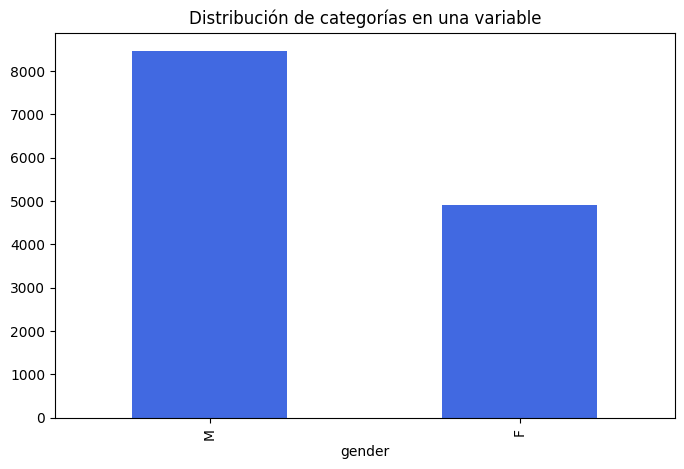

In [40]:
plt.figure(figsize=(8,5))
df['gender'].value_counts().plot(kind='bar', color='royalblue')
plt.title("Distribución de categorías en una variable")
plt.show()

**Hallazgos:**

- Aproximadamente 8,000 individuos masculinos (M)
- Aproximadamente 5,000 individuos femeninos (F)
- Desbalance de aproximadamente 60% hombres y 40% mujeres en la muestra
- Esta proporción desigual debe considerarse al interpretar los resultados generales

### **Ver la distribución de clases según el género.**

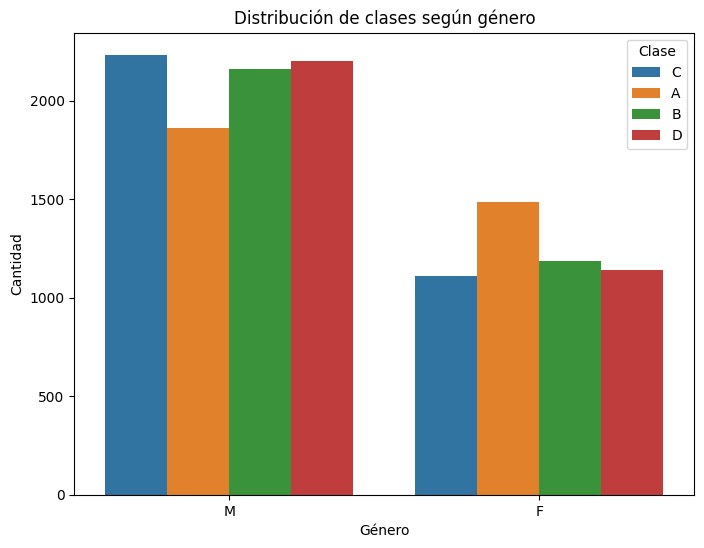

In [41]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="gender", hue="class")
plt.title("Distribución de clases según género")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.legend(title="Clase")
plt.show()

### Distribución de clases por género

| Género | Observaciones Principales                                   | Distribución Aproximada |
|--------|-------------------------------------------------------------|--------------------------|
| **Hombres (M)** | - Mayor representación de clases **C** y **D**  <br> - Menor representación de clase **A** | C > D > B > A            |
| **Mujeres (F)** | - Mayor representación de clase **A**  <br> - Distribución más equilibrada entre clases | A > B ≈ C ≈ D            |

- La clase A está significativamente sobrerrepresentada en mujeres en comparación con hombres

- La clase C está significativamente sobrerrepresentada en hombres en comparación con mujeres

### **Comparar diferencias entre géneros para una variable específica**

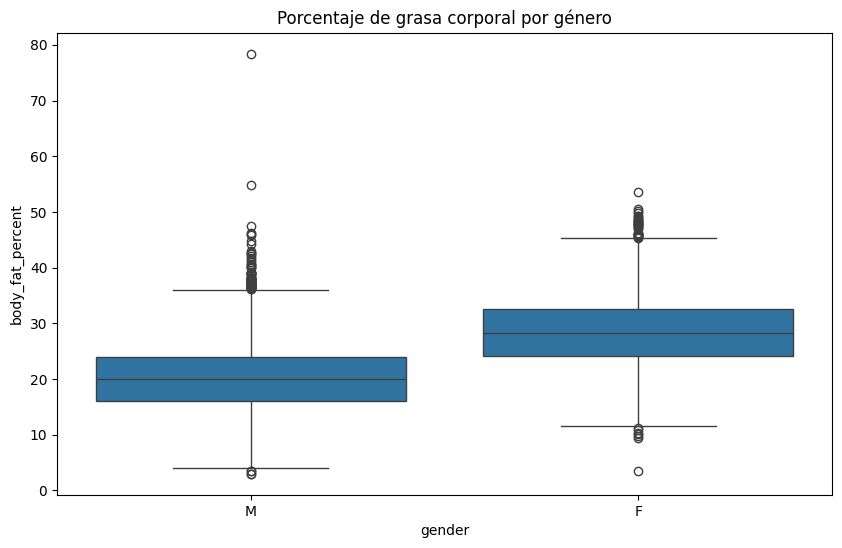

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="gender", y="body_fat_percent")
plt.title("Porcentaje de grasa corporal por género")
plt.show()

**Media y desviación estándar de sit-ups por clase**
Este gráfico de barras con barras de error muestra el rendimiento promedio en sit-ups para cada clase.

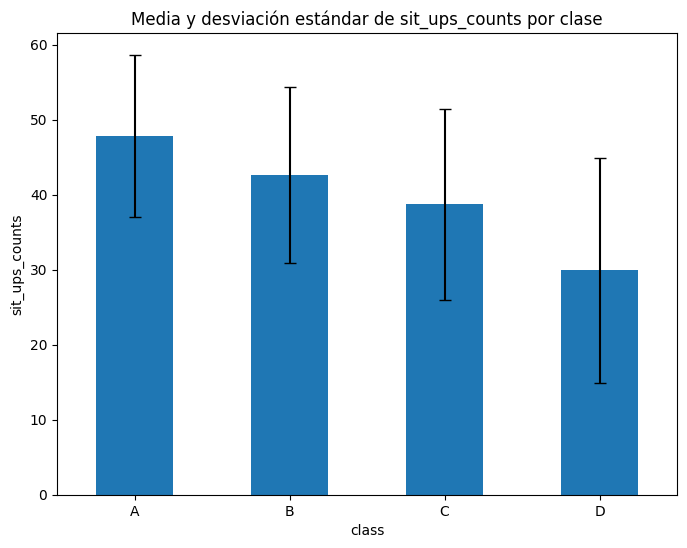

In [ ]:
feature = "sit_ups_counts"  
grouped = df.groupby("class")[feature].agg(["mean", "std"]).sort_index()

grouped.plot(kind="bar", y="mean", yerr="std", legend=False, figsize=(8,6), capsize=4)
plt.title(f"Media y desviación estándar de {feature} por clase")
plt.ylabel(feature)
plt.xticks(rotation=0)
plt.show()

**Hallazgos:**

- **Clase A:** Mayor promedio de sit-ups (~48) con desviación estándar de ~10

- **Clase B:** Segundo mejor rendimiento (~42) con desviación estándar similar
- **Clase C:** Rendimiento moderado (~38) con desviación estándar ~12
- **Clase D:** Menor rendimiento (~30) con mayor variabilidad (desviación estándar ~15)
- **Patrón claro:** A > B > C > D en términos de rendimiento en sit-ups
- **Las barras de error (desviación estándar)** muestran superposición, indicando que las diferencias, aunque claras en promedio, tienen variabilidad significativa

### **Visualizar la distribución de una variable como por clase**
Este gráfico radar compara el perfil promedio de cada clase a través de múltiples variables.

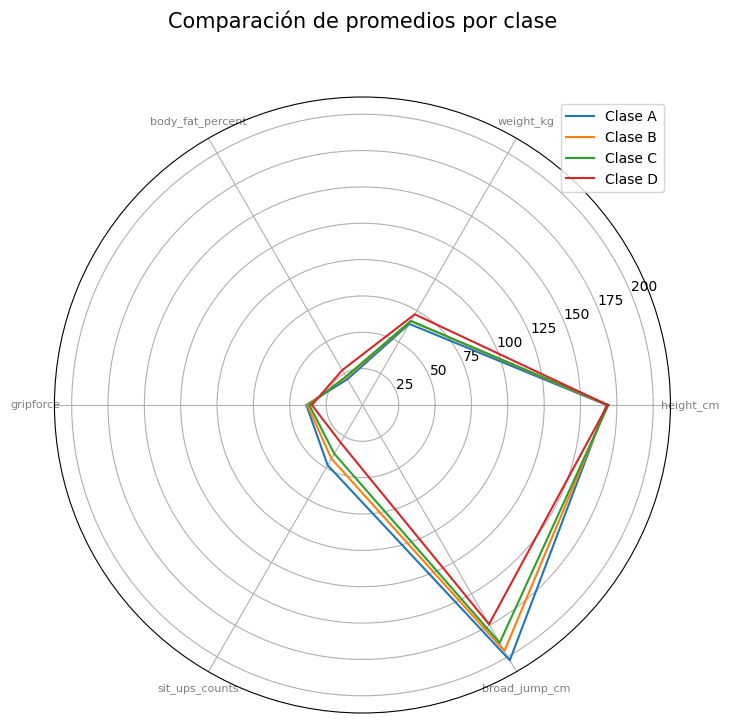

In [46]:
# Preparamos promedios por clase
features = ['height_cm', 'weight_kg', 'body_fat_percent', 'gripforce', 'sit_ups_counts', 'broad_jump_cm']
df_mean = df.groupby("class")[features].mean()

# Radar chart
categories = features
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # cerrar el círculo

plt.figure(figsize=(8, 8))
for idx, row in df_mean.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Clase {idx}')
    
plt.xticks(angles[:-1], categories, color='grey', size=8)
plt.title('Comparación de promedios por clase', size=15, y=1.1)
plt.legend()
plt.show()


**Hallazgos principales:**

- **Clase A (azul):** Destaca en broad_jump_cm y sit_ups_counts, menor en body_fat_percent

- **Clase D (rojo):** Mayor en body_fat_percent, menor en broad_jump_cm y sit_ups_counts
- **Clases B y C:** Perfiles intermedios entre A y D
- Todas las clases muestran valores similares en height_cm
- La forma del polígono sugiere que las clases representan niveles de aptitud física, con A siendo la más alta y D la más baja
- El gráfico confirma la relación inversa entre porcentaje de grasa corporal y rendimiento físico

**Promedios por clase para variables seleccionadas (Heatmap)**

Este mapa de calor muestra los valores promedio de cada variable por clase, con la intensidad del color representando el valor.

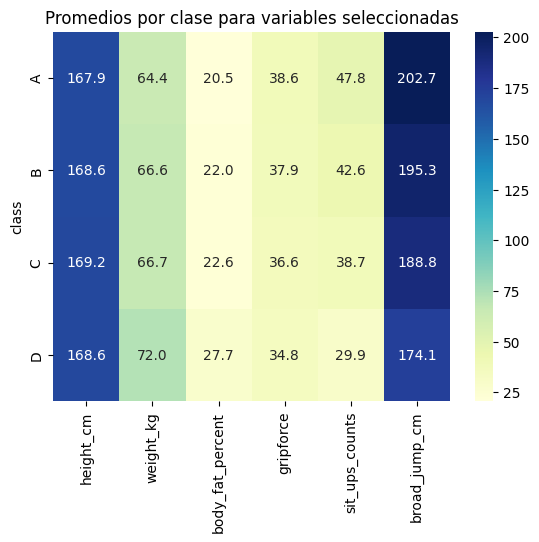

In [47]:
mean_by_class = df.groupby('class')[features].mean()
sns.heatmap(mean_by_class, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Promedios por clase para variables seleccionadas")
plt.show()


**Hallazgos principales:**

- **Altura (height_cm):** Valores similares entre clases (~168-169 cm)

- **Peso (weight_kg):** Aumenta progresivamente de clase A (64.4) a D (72.0)
- **Body fat percent:** Aumenta progresivamente de clase A (20.5%) a D (27.7%)
- **Fuerza de agarre:** Disminuye de clase A (38.6) a D (34.7)
- **Sit-ups counts:** Disminuye significativamente de clase A (47.8) a D (29.9)
- **Broad jump:** Disminuye de clase A (202.7 cm) a D (173.8 cm)
- Se confirma el patrón de aptitud física decreciente de A→D
- La clase D se caracteriza por mayor peso y grasa corporal, pero menor rendimiento físico

**Fuerza de agarre vs. abdominales, coloreado por clase**

Este gráfico de dispersión muestra la relación entre fuerza de agarre (eje X) y repeticiones de abdominales (eje Y), con puntos coloreados según la clase.

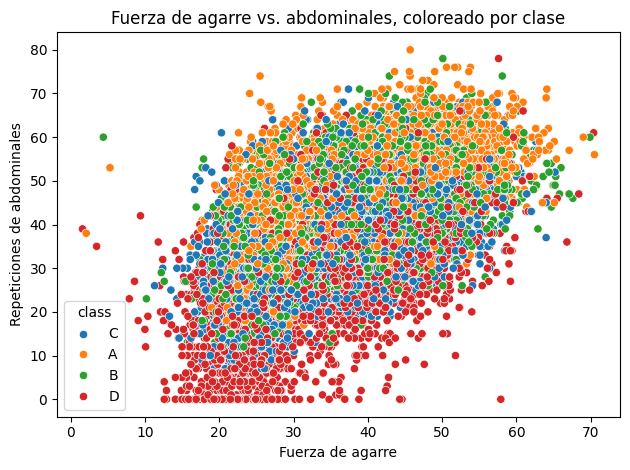

In [48]:
# Relación entre fuerza de agarre y abdominales por clase
plt.figure()
sns.scatterplot(x="gripforce", y="sit_ups_counts", hue="class", data=df)
plt.title("Fuerza de agarre vs. abdominales, coloreado por clase")
plt.xlabel("Fuerza de agarre")
plt.ylabel("Repeticiones de abdominales")
plt.tight_layout()
plt.show()

- Correlación positiva moderada-fuerte entre fuerza de agarre y capacidad de abdominales

- Clase A (naranja): Concentrada en región superior derecha (alto rendimiento en ambas variables)
- Clase D (rojo): Concentrada en región inferior (bajo rendimiento en abdominales)
- Clases B y C: Distribución más amplia a través del gráfico
- Existe un número significativo de individuos con valor cero en abdominales, especialmente en clase D
- La correlación positiva confirma que la fuerza general puede ser un predictor de rendimiento en abdominales

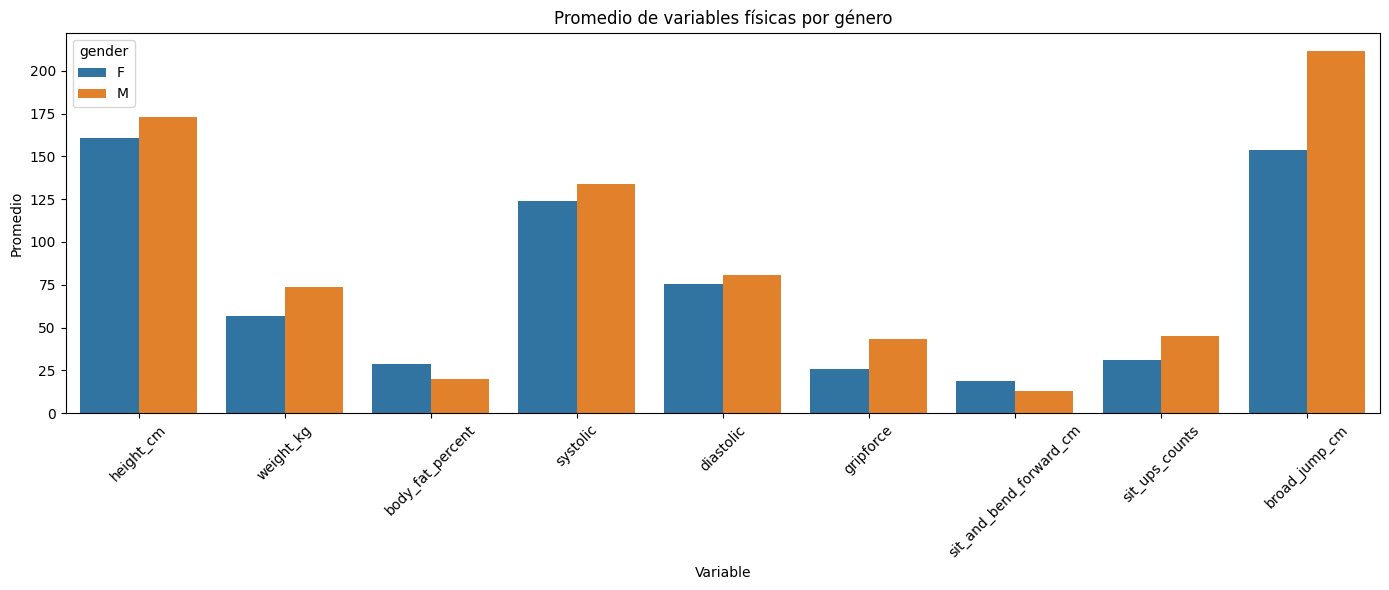

In [49]:
variables = ['height_cm','weight_kg','body_fat_percent','systolic','diastolic','gripforce','sit_and_bend_forward_cm',
    'sit_ups_counts','broad_jump_cm']

mean_by_gender = df.groupby('gender')[variables].mean().reset_index()

# Convertir a formato largo para seaborn
mean_long = mean_by_gender.melt(id_vars='gender', var_name='Variable', value_name='Promedio')

plt.figure(figsize=(14, 6))
sns.barplot(data=mean_long, x='Variable', y='Promedio', hue='gender')
plt.title('Promedio de variables físicas por género')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Altura: Hombres (~175 cm) > Mujeres (~160 cm)
- Peso: Hombres (~75 kg) > Mujeres (~55 kg)
- Grasa corporal: Mujeres (~28%) > Hombres (~20%), única variable donde mujeres superan a hombres
- Presión arterial: Ligeramente superior en hombres
- Rendimiento físico: Hombres superan significativamente a mujeres en:
    - Fuerza de agarre (~43 vs ~25)
    - Sit-ups counts (~45 vs ~30)
    - Broad jump (~210 cm vs ~150 cm)

- La diferencia es menos pronunciada en sit_and_bend_forward_cm

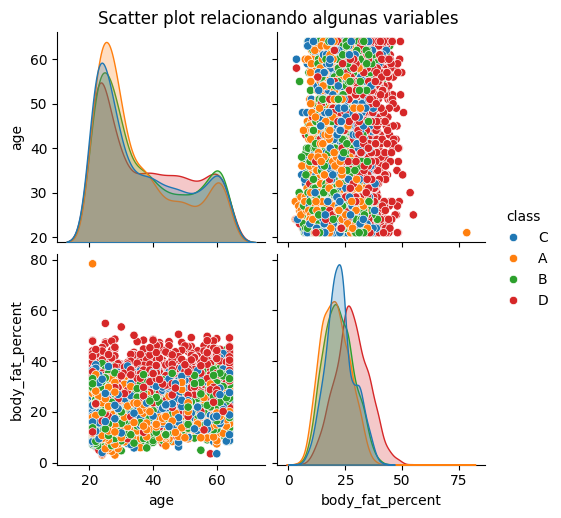

In [50]:
cols = ["age", "body_fat_percent"] 
sns.pairplot(df[cols + ["class"]], hue="class")  # Solo esas columnas + la de hue
plt.gcf().suptitle("Scatter plot relacionando algunas variables", y=1.02) 
plt.show()

**Hallazgos principales:**

- La distribución de edad muestra un patrón bimodal con picos alrededor de 25 y 35 años
- No hay una separación clara de las clases por edad (panel superior derecho)
- El porcentaje de grasa corporal no muestra una fuerte relación con la edad (panel inferior izquierdo)
- La distribución del porcentaje de grasa corporal (panel inferior derecho) es aproximadamente normal con un ligero sesgo positivo
- Las clases (A, B, C, D) parecen distribuirse uniformemente a través de las variables visualizadas, sin mostrar agrupación clara

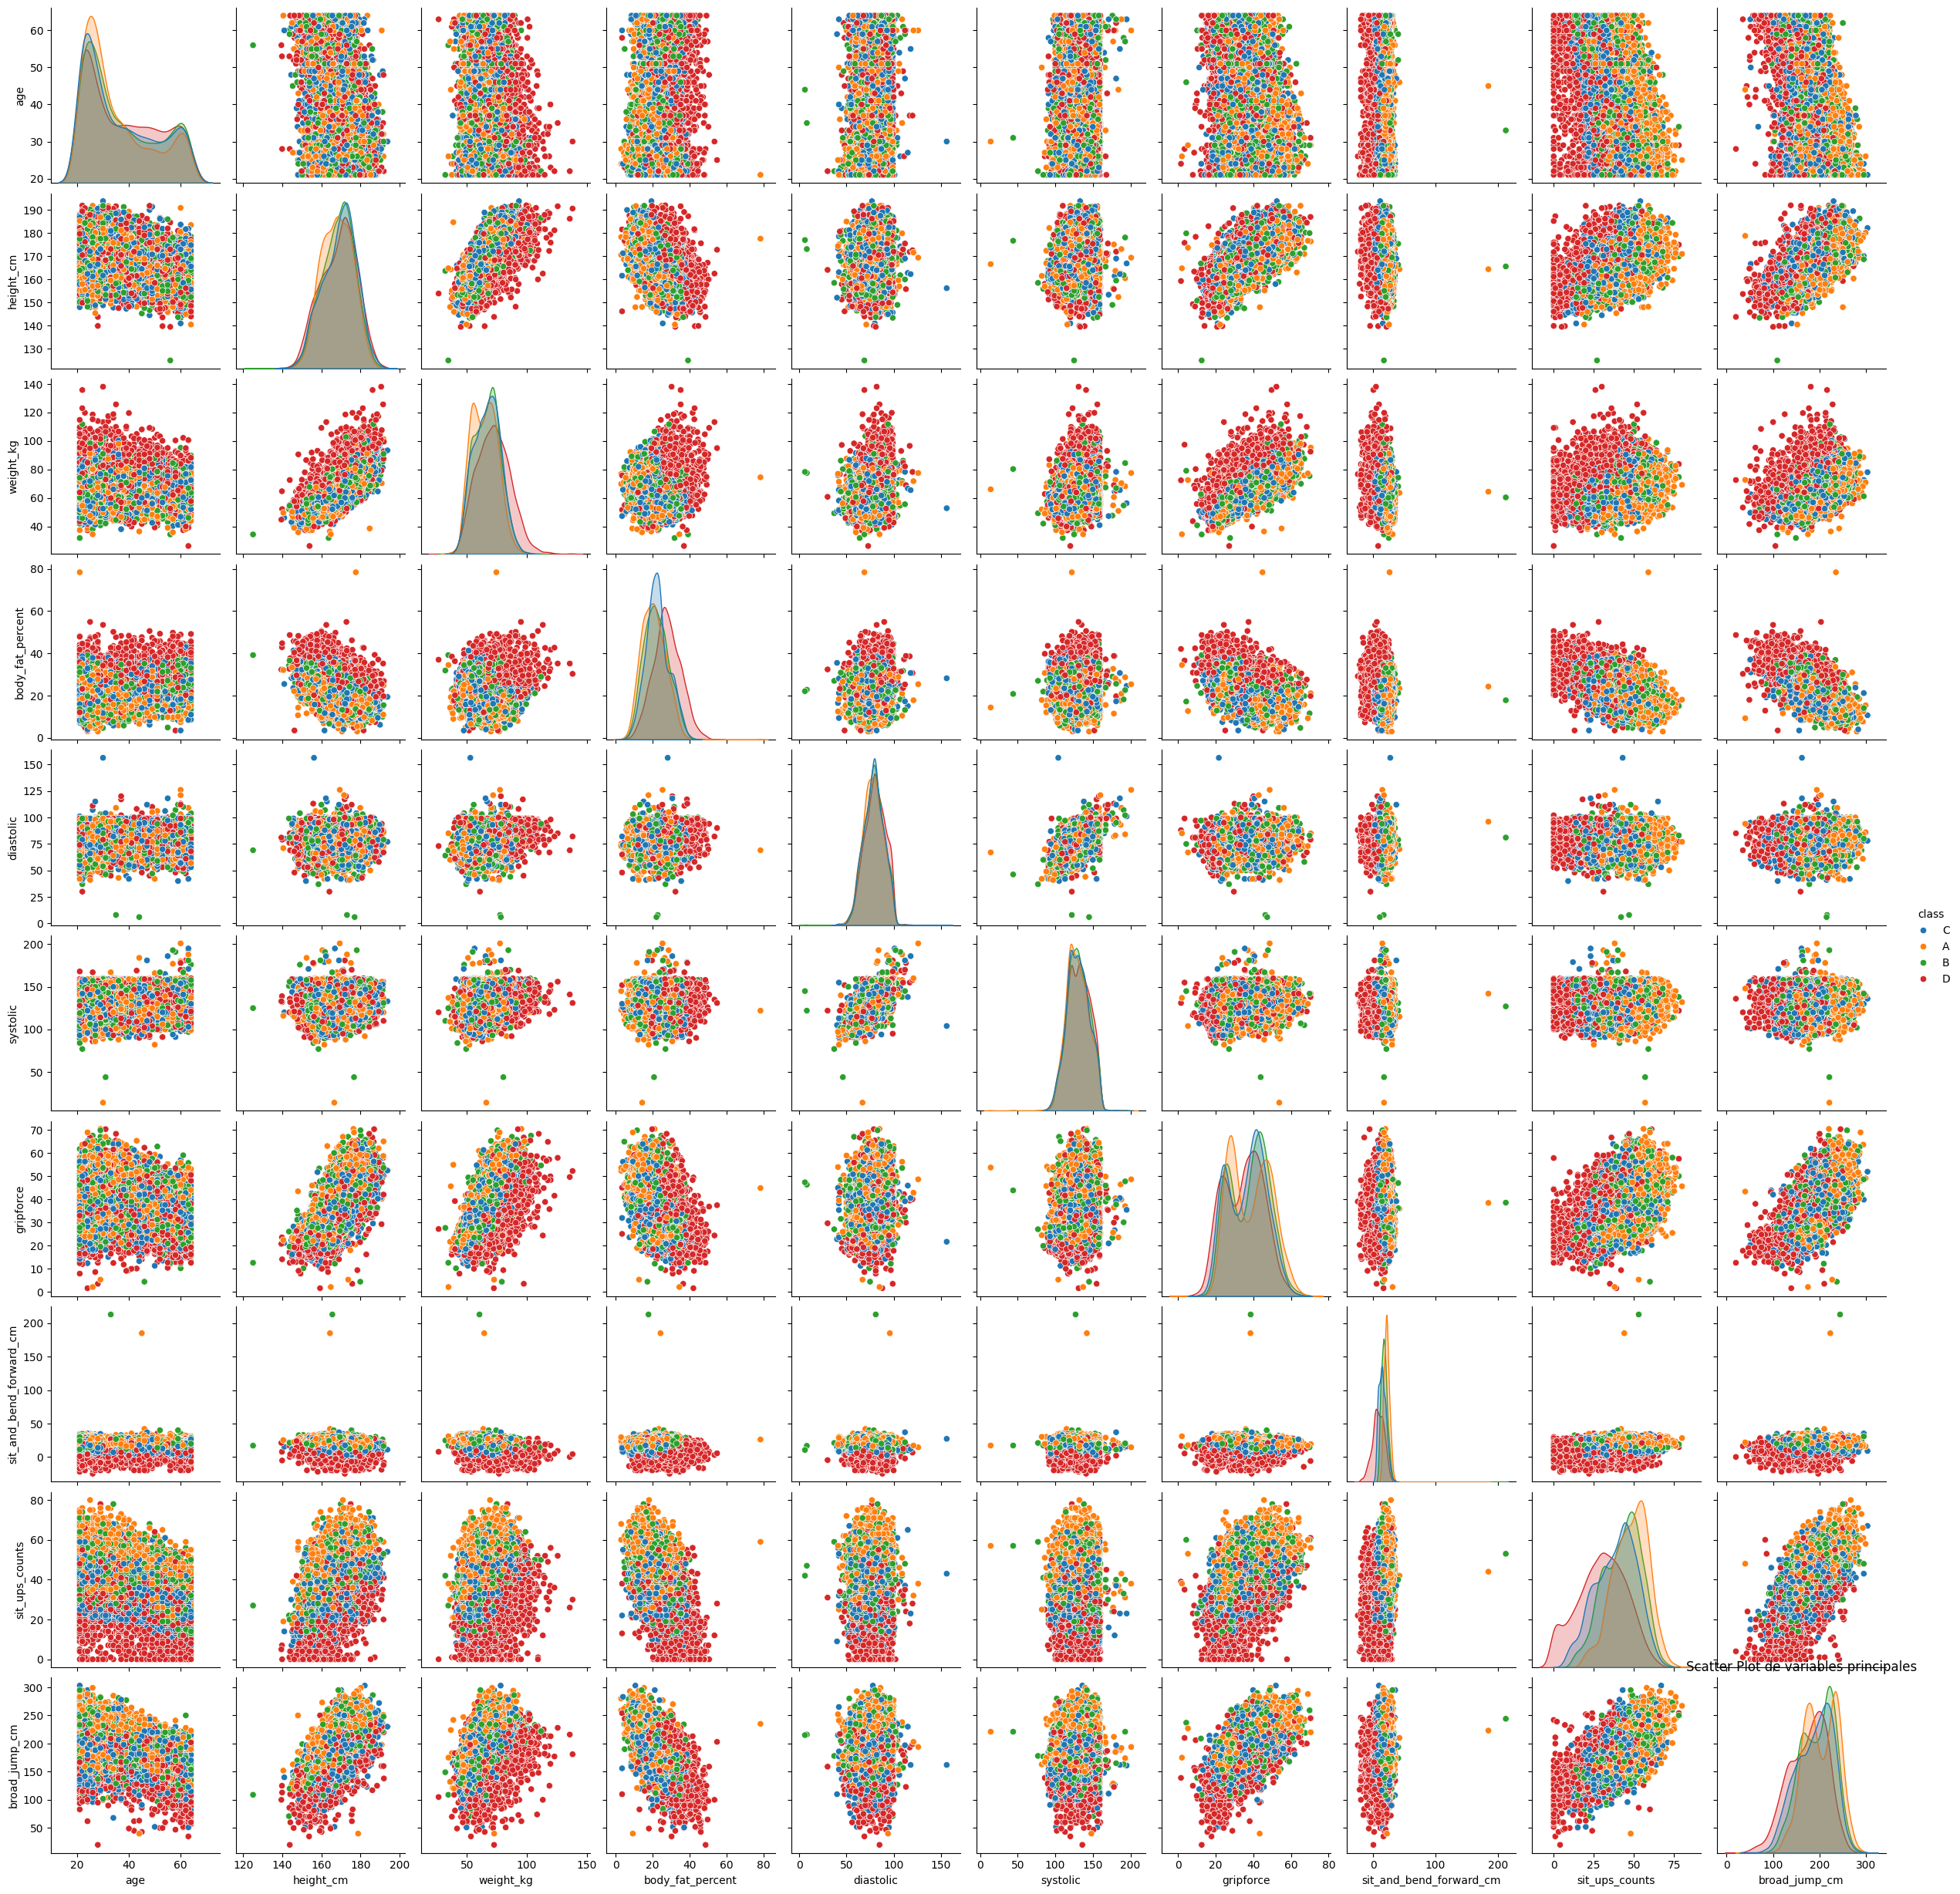

In [ ]:
sns.pairplot(df, hue="class")
plt.title("Scatter Plot de variables principales")
plt.show()

**Hallazgos:**

- Confirma las correlaciones observadas en la matriz de correlación (Imagen 1)
- Muestra claramente los patrones bimodales en variables como altura y fuerza de agarre (reflejando diferencias de género)
- Visualiza relaciones no lineales entre algunas variables que no se capturan completamente en coeficientes de correlación
- Las clases muestran cierta separación en algunos gráficos, especialmente en los relacionados con rendimiento físico
- Se observan agrupaciones (clusters) relacionadas con el género en muchas de las relaciones bivariadas
- Los histogramas en la diagonal complementan la Imagen 3, mostrando las distribuciones individuales